# Built In Beam in Bending

In [1]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log,default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem,LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile, VTXWriter
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split,TestFunction,indices,as_tensor)
from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime, timedelta
from dolfinx.plot import vtk_mesh
from dolfinx.fem.petsc import  assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc,create_matrix, create_vector
import basix
import pyvista
pyvista.set_jupyter_backend('client')

from ElasticPlasticity.Plastic_material import Plastic_Material
from ElasticPlasticity.Plastic_Visibility import Problem_Saver
from ElasticPlasticity.Plasticity_Funcs import *
from ElasticPlasticity.Plasticity_Problem import Plastic_Problem_Def

In [2]:
problem_name = "Plastic Bending Traction"
# Geometric parameters
geom = {"longside" : 100.0,     # mm
        "side" : 10.0,      # mm
        "num_elements" : 5,    # size of a cell
        }


# Mechanicals parameters
mech = {"E" : 300e3,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 180.0,  # MPa
        "H" : 20.0, # MPa
        "r" : 1.0,
        "Y_s" :300.0,#mpa
        "C" : 60.0e3,
        "gamma":10.0
        
        }


# Study parameters
stud = {"deg_u" : 1,    # Interpolation of u
        "deg_stress" : 2,  # Interpolation of sig, eps, p
        }

load_steps  = {
        "N_incr" : 60,  # Number of load steps
        "max_disp" : 3.0 # Maximal displacemen
        }


# Domain and Boundary Definition

In [3]:
domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0.0],[geom["longside"],geom["side"],geom["side"]]],[geom["num_elements"]*10,geom["num_elements"],geom["num_elements"]])


def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], geom["longside"])
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], geom["side"])
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], geom["side"])

boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [4]:
mat = Plastic_Material(domain = domain,**mech)
plastic_problem = Plastic_Problem_Def(domain,mat,facet_tags=facet_tag,**stud)

# Boundary Conditions

In [5]:



left_facets = facet_tag.find(1)

right_facets = facet_tag.find(2)


top_facets = facet_tag.find(3)
side_facets = facet_tag.find(5)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, domain.topology.dim)
disp = Constant(domain,0.0)

left_dofs_x = fem.locate_dofs_topological(plastic_problem.V, fdim, left_facets)

right_dofs_x = fem.locate_dofs_topological(plastic_problem.V.sub(1),fdim, right_facets)

sym_bottom = fem.dirichletbc(np.array((0.0,0.0,0.0),dtype=default_scalar_type), left_dofs_x, plastic_problem.V)
sym_left = fem.dirichletbc(disp, right_dofs_x, plastic_problem.V.sub(1))



bcs = [sym_bottom]

#bcs = [sym_bottom, sym_left]

disp = Constant(domain,(0.0,0.0,0.0))


def F_ext(t):
    arr = np.zeros((3,))
    arr[1] = t*8
    return arr

In [6]:
plastic_problem._init_linear_problem([(-disp,plastic_problem.ds(2))])

# Data for Plotting

In [7]:
E_n = eps(plastic_problem.u)
E_p = plastic_problem.E_p

Stress_Point = mat.sigma(E_n - E_p)
area= Constant(domain,(geom["side"]*geom["side"]))
Elastic = Function(plastic_problem.V_scal)

project(Stress_Point[0,1],Elastic)
engineeringStress= fem.form(Elastic/area*plastic_problem.ds(2)) #P22/area*ds


pointForStress = [geom["longside"],5,5]

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))

In [8]:
saver = Problem_Saver(plastic_problem,problem_name)


# Problem Solving

In [9]:
K = 25*2  # number of steps per load phase
Z = 2  # number of cycles
load, unload,load_2 = np.linspace(0.0, 1.0, num=K + 1), np.linspace(1.0, 0, num=K+ 1), np.linspace(-1.0, 1.0, num=K + 1)
cycle = np.concatenate((unload, load_2, unload,load_2))
cycles = np.concatenate([load]+[unload])
loads = cycles

In [10]:
startTime = datetime.now()
Nincr = load_steps["N_incr"]

results = np.zeros((len(cycles)+1, 4))
#F = np.vectorize(F_ext)


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

#log.set_log_level(log.LogLevel.INFO)
saver.update_and_save(0)
for (i, load) in enumerate(loads):
    # Update Diriclet boundary condition
   
    disp.value = F_ext(load)
    # Update the right hand side reusing the initial vector

    print("Increment:", str(i+1))
    niter = 0
    print("Linear Step 1 Start")
    plastic_problem.solve_linear(bcs) #Solves for the first trial displacement
    
    
    scal = fem.assemble_vector(plastic_problem.f_trial)
    print("Linear Step 1 Done")
    if scal.array.max() >= 0:
        error_0 = scal.array.max()
        niter = 0
        nls_ttime = timedelta(0,0,0)
        linear_ttime = timedelta(0,0,0)
        print("Starting Plastic Step")
        #while scal.array.max() >= 10 and niter < 10 and scal.array.max()/error_0 >.3:
           
            
        nls_time = datetime.now()
        plastic_problem.solve_nls()
        nls_ttime += datetime.now() - startTime
        linear_time = datetime.now()
        #print("Stop Plastic Step  Done")
        # print("Linear Step 2 Start")
        #f_trial = fem.assemble_scalar(fem.form(plastic_problem.res_p))
        #print(f_trial.norm())
    
        plastic_problem.solve_linear(bcs) #Solves for the actual displacement after the plastic update
        linear_ttime += datetime.now() - startTime
        plastic_problem.u.x.array[:] += plastic_problem.du.x.array[:]
        plastic_problem.du.x.array[:] = 0.0
        plastic_problem.dp.x.array[:] = 0.0
            # print("Linear Step 2 Done")
            
            #scal = fem.assemble_vector(plastic_problem.f_trial)
            #print(scal.array.max())
            #niter +=1
        print(f"Number of iterations: {niter}")
        print(f"Nonlinear time: {nls_ttime}")
        print(f"Linear time: {linear_ttime}")
    
    
    else:
        print("Skiping Plastic Step")
        
        #vec1 = fem.assemble_vector(fem.form(plastic_problem.res_p))
        #print(plastic_problem.du.x.array)
        plastic_problem.u.x.array[:] += plastic_problem.du.x.array[:]
        plastic_problem.du.x.array[:] = 0.0
        plastic_problem.dp.x.array[:] = 0.0
    
    
    project(Stress_Point[0,1],Elastic)
    u_pointe = plastic_problem.u.eval(pointForStress,colliding_cells.array[0])[1]
    stress =  domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    #vec2 = fem.assemble_vector(fem.form(plastic_problem.res_p))
    #print(vec1.norm())
    #print(vec2.norm())
    results[i + 1, :] = (u_pointe,stress,i+1,F_ext(load)[1])
    
    saver.update_and_save(i)
    

print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")    
saver.close()

------------------------------------
Simulation Start
------------------------------------
Increment: 1
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 2
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 3
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 4
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 5
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 6
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 7
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 8
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 9
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 10
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 11
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 12
Linear Step 1 Start
Linear Step 1 Done
Skiping Plastic Step
Increment: 13
Linear Step 1 St

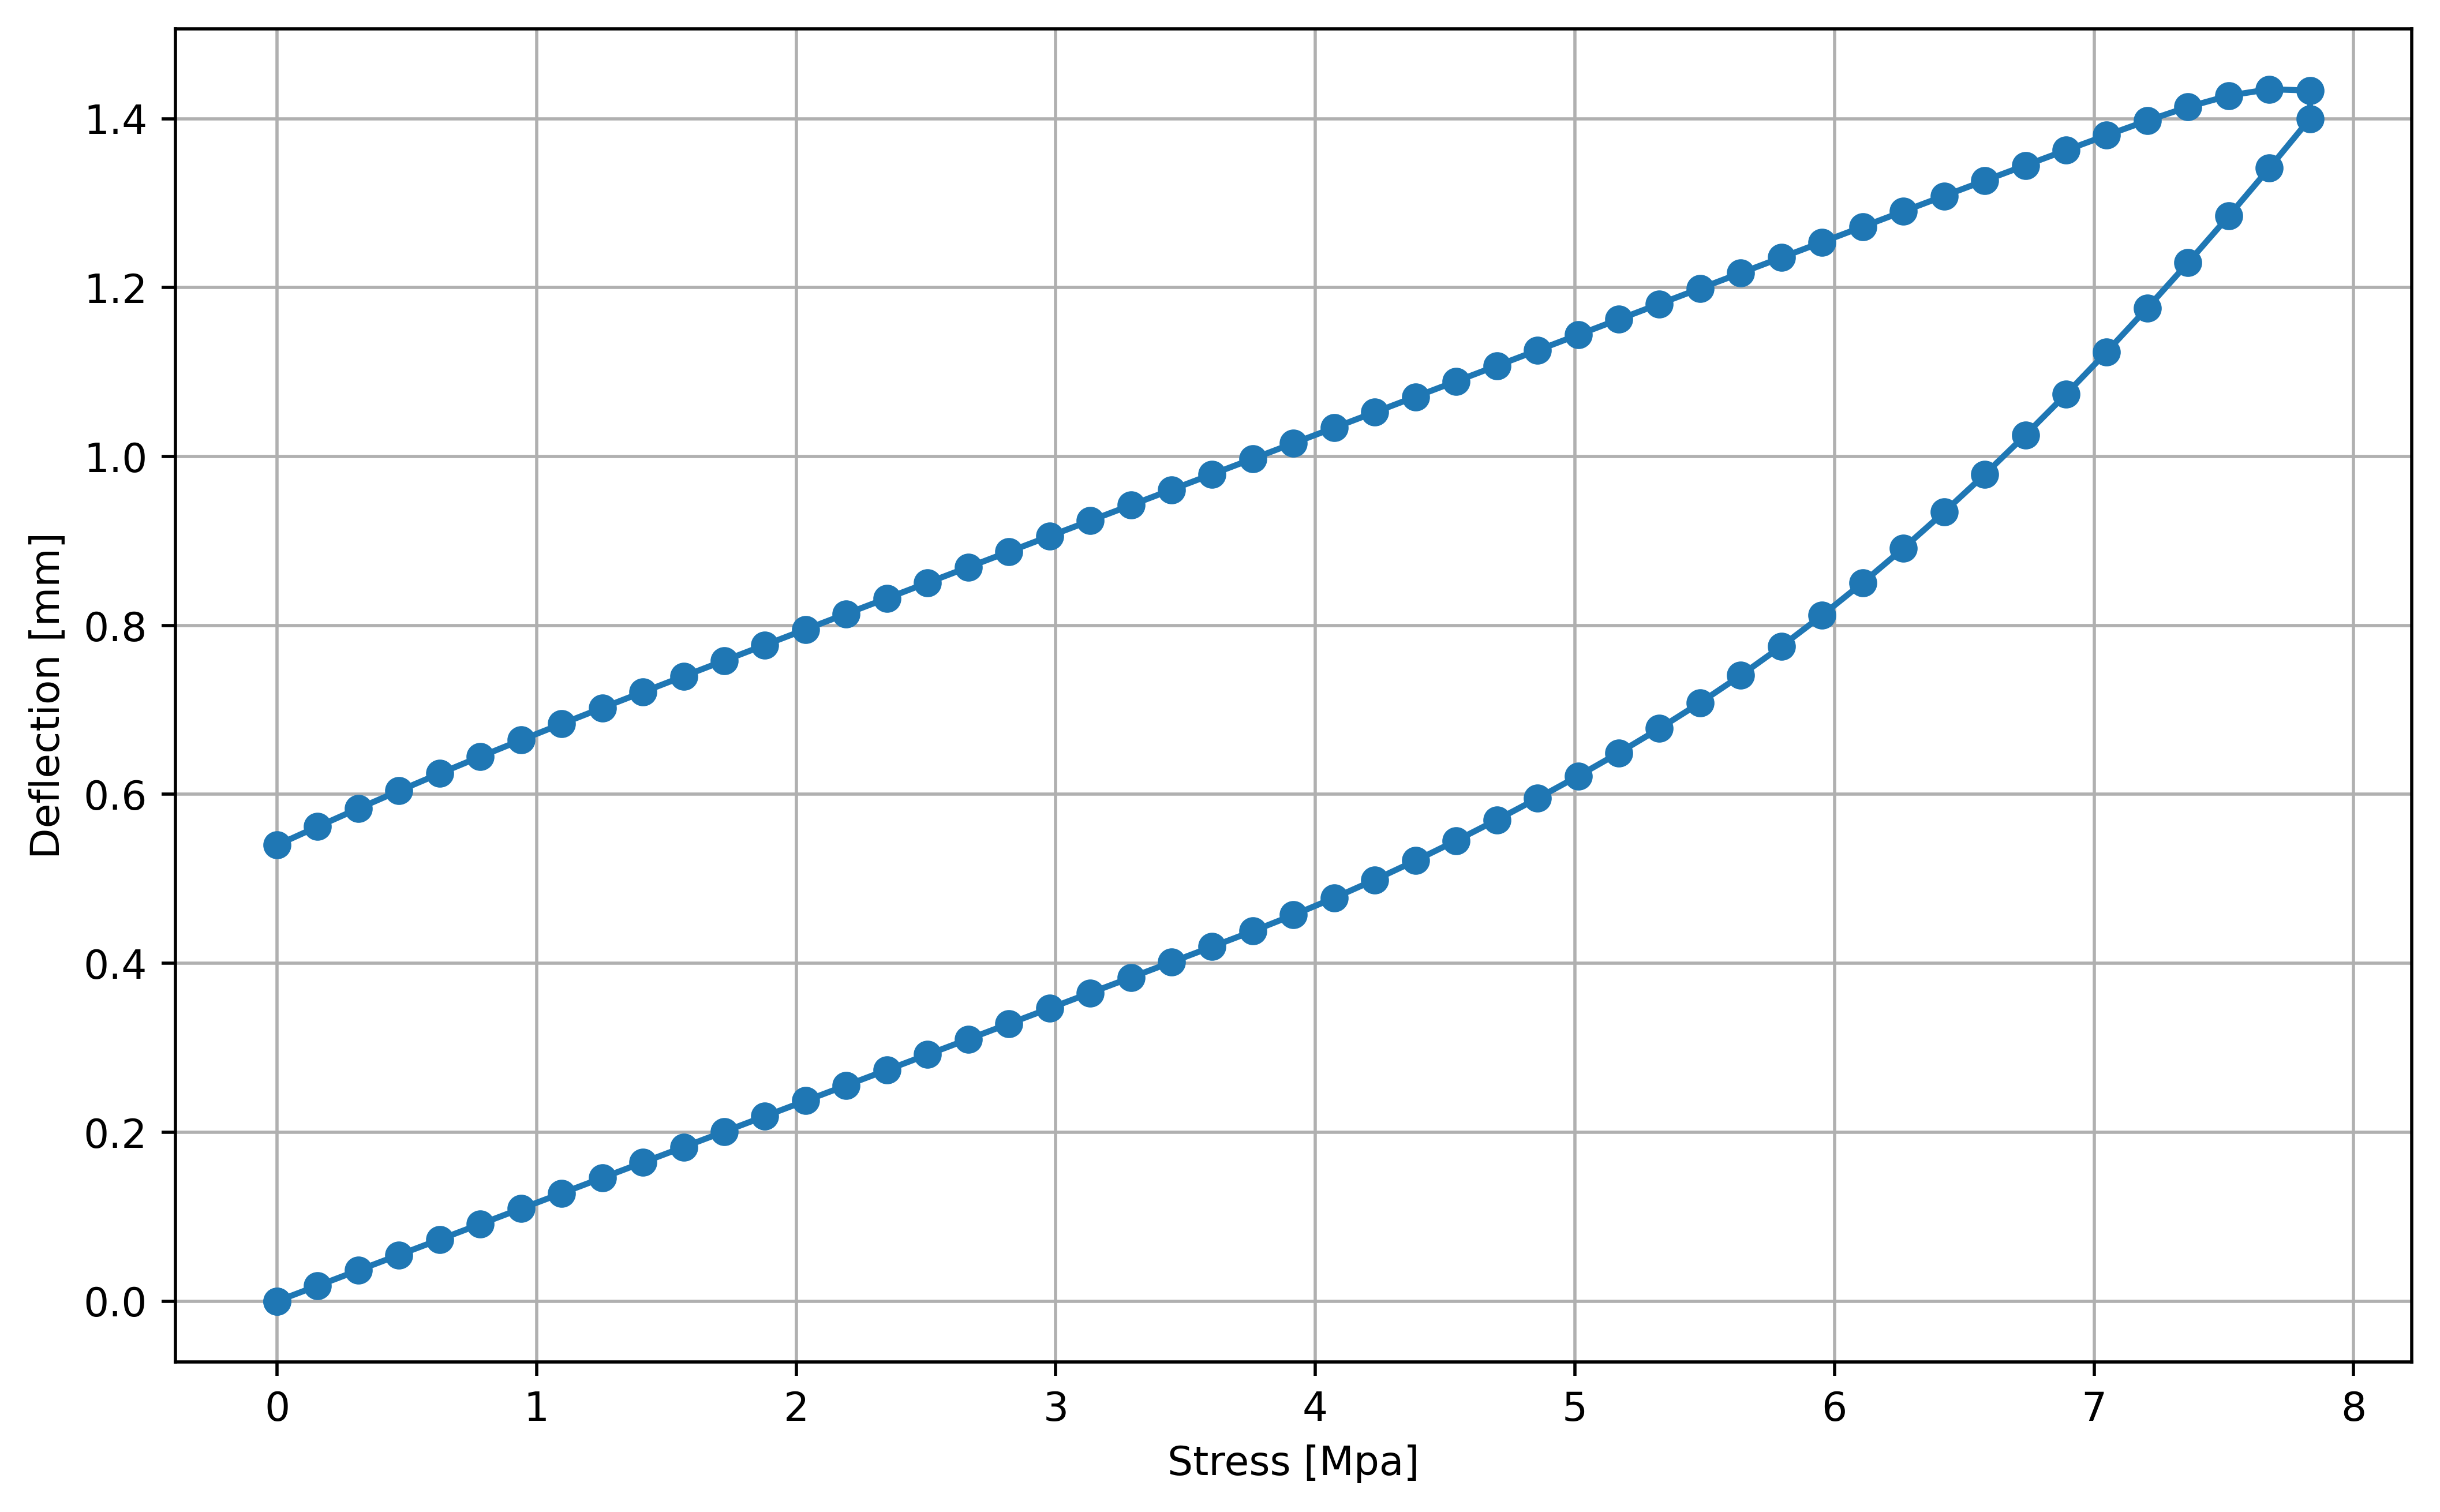

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=500)
plt.plot(results[:, 1], results[:, 0], "-o")

#plt.plot(results[:, 0]/geom["longside"], results[:, 3], "-o")
plt.xlabel(r"Stress [Mpa]")
plt.ylabel(r"Deflection [mm]")
plt.grid()
plt.show()